In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

# Atenção: movi estas células para o notebook 00-PrepareData.
Vou deixar este notebook aqui para fazer testes.

## Funções para extrair acertos
A maioria das análises TRI vão precisar de uma "dicomitização" das respostas. A estrutura de dados que vamos precisar é uma matriz com colunas itens e linhas pessoas com valores 0 e 1 para erros e acertos respectivamente.

Vamos tentar criar umas funções que crie este estrutura de dados.


Temos algumas informações sobre a estrutura dos microdados:
* não vamos usar as primeiras 10 itens da prova LC (Linguágens e Códigos). Desde 2011 (?) estas posições são usadas para as questões de língua estrangeira (espanhol ou inglês). Acredito que somente 40 questões de LC são usados para criar a escala IRT desta prova.
* O INEP divulga, desde o final de 2022, os parámetros IRT (discriminação, dificuldade e c). Além disso, dizem quais itens foram eliminados ("pelo IRT"), porque aparentemente atrapalharam a convergência da estimação do modelo IRT 3PL que estão usando. Vamos ter que tirar estes itens também.  

In [119]:
def load_data(ano,perc):
    df = pd.read_csv(f'data/enem_{perc}_{ano}.csv',dtype={'CO_PROVA_LC':int,'CO_PROVA_CN':int,'CO_PROVA_CH':int,'CO_PROVA_MT':int})
    item_info = pd.read_csv(f'../inep/enem/{ano}/DADOS/ITENS_PROVA_{ano}-utf8.csv',sep='\;')
    item_info.dropna(subset='CO_ITEM',inplace=True)
    item_info['CO_ITEM'] = item_info['CO_ITEM'].astype(int)
                     
    #print(list(item_info.columns),'\n')
    #print(list(df.columns))
    return df, item_info

df, itens = load_data(2014,1)


/tmp/ipykernel_6828/3774982071.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  item_info = pd.read_csv(f'../inep/enem/{ano}/DADOS/ITENS_PROVA_{ano}-utf8.csv',sep='\;')


In [133]:
df['

,NU_INSCRICAO,NU_ANO,TP_FAIXA_ETARIA,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,...,Q067,Q068,Q069,Q070,Q071,Q072,Q073,Q074,Q075,Q076
0,140000000077,2014,5,F,0,3,1,1,2011.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,140000000184,2014,2,M,0,2,1,2,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,140000000194,2014,13,F,1,2,1,1,2004.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,140000000364,2014,11,F,1,2,1,1,2008.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,140000000588,2014,8,F,0,3,1,1,2008.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45440,140008721159,2014,3,M,0,1,1,2,NaN,1.0,...,B,B,B,B,B,B,B,B,B,G
45441,140008721294,2014,5,F,0,1,1,1,2011.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45442,140008722016,2014,3,M,0,3,1,2,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45443,140008722330,2014,2,M,0,1,1,2,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [120]:
itens.query("IN_ITEM_ABAN == 1")

,CO_POSICAO,SG_AREA,CO_ITEM,TX_GABARITO,CO_HABILIDADE,IN_ITEM_ABAN,TX_MOTIVO_ABAN,NU_PARAM_A,NU_PARAM_B,NU_PARAM_C,TX_COR,CO_PROVA,TP_LINGUA,IN_ITEM_ADAPTADO
410,51,CN,49314,A,8.0,1,Não permitiu a convergência do algoritmo de es...,NaN,NaN,NaN,Azul,199,NaN,NaN
412,53,CN,45270,A,3.0,1,Não permitiu a convergência do algoritmo de es...,NaN,NaN,NaN,Azul,199,NaN,NaN
451,47,CN,49314,A,8.0,1,Não permitiu a convergência do algoritmo de es...,NaN,NaN,NaN,Amarelo,200,NaN,NaN
485,81,CN,45270,A,3.0,1,Não permitiu a convergência do algoritmo de es...,NaN,NaN,NaN,Amarelo,200,NaN,NaN
512,63,CN,45270,A,3.0,1,Não permitiu a convergência do algoritmo de es...,NaN,NaN,NaN,Branco,201,NaN,NaN
539,90,CN,49314,A,8.0,1,Não permitiu a convergência do algoritmo de es...,NaN,NaN,NaN,Branco,201,NaN,NaN
572,78,CN,45270,A,3.0,1,Não permitiu a convergência do algoritmo de es...,NaN,NaN,NaN,Rosa,202,NaN,NaN
577,83,CN,49314,A,8.0,1,Não permitiu a convergência do algoritmo de es...,NaN,NaN,NaN,Rosa,202,NaN,NaN
647,63,CN,45270,A,3.0,1,Não permitiu a convergência do algoritmo de es...,NaN,NaN,NaN,Branco-Ledor,216,NaN,1.0
674,90,CN,49314,A,8.0,1,Não permitiu a convergência do algoritmo de es...,NaN,NaN,NaN,Branco-Ledor,216,NaN,1.0


In [125]:
df[["TX_RESPOSTAS_CH","TX_GABARITO_CH"]].sample(10)

,TX_RESPOSTAS_CH,TX_GABARITO_CH
30523,CEEDAABBAAEBABCAEBAEACDCCCEEAEEDBEB.D.CBBADEC,AADEAABBEADBABBDADBCCEECCEDECBCABDBACCEDEADEC
19965,CCBEACEAAAEACCABADADBEAEEDCBEABDCEBCDCDBBBCCC,AABBEAADEADBABCEDBDADDEECECCEADECBDBACBCABCCE
27002,CCEBABACBCACEBADAECDAEBCAABECECBCBEACACACAADB,ECBDADADECAABBECBCCEADBABDEECAADECEDCEBDBABCA
5226,AADEBCDBAEBEDBACEBEACDECDAABDBECBCEBDBDACDEBA,AADEAABBEADBABBDADBCCEECCEDECBCABDBACCEDEADEC
40939,ADECECACABCAAEAAEEDDDCEEBBDABBCEBBBEAEAADCEEE,ADECECBCCECAABBEBCABDBAECCEDEBDADCEDADBABAADE
12343,EBEAEDABDEAEBABCBCCEAEBEDAEEEACEBABCCAEACEEEA,ECBDADADECAABBECBCCEADBABDEECAADECEDCEBDBABCA
24357,ACDBEC*CBDDBDDECBEDEAECDBDBBBDEEDCBCCEEEACAED,ADECECBCCECAABBEBCABDBAECCEDEBDADCEDADBABAADE
32007,ADECEDBCEACBAEBEADADACCEDBCADAAEBCACBDADCBAEC,ADECECBCCECAABBEBCABDBAECCEDEBDADCEDADBABAADE
3462,ACBBCAEBBACADCCDEBCADEDEBCCABADDEBBDECBEDAACE,AABBEAADEADBABCEDBDADDEECECCEADECBDBACBCABCCE
40434,AACBBADDEADBCECEBCDADDEEBECCEADECBABACBAABCCD,AABBEAADEADBABCEDBDADDEECECCEADECBDBACBCABCCE


In [165]:
df['TX_RESPOSTAS_MT'].describe()

count                                             45444
unique                                            45392
top       CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
freq                                                 16
Name: TX_RESPOSTAS_MT, dtype: object

In [127]:
gab = df.loc[19965,"TX_GABARITO_CH"]
resp = df.loc[19965,"TX_RESPOSTAS_CH"]
print(len(resp))
print(len(gab))

45
45


In [128]:
[r == g for r,g in zip(resp,gab)]

[False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 True,
 True,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 True,
 True,
 False]

In [160]:
def to_acertos(s):
    'resp e gab são strings, retorna uma lista'
    resp = s.iloc[0]
    gab = s.iloc[1]
    return [r == g for r,g in zip(resp,gab)]

def acertos_df(df,exame,as_int=True):
    'Retorna dataframe com acertos. Colunas 1-45 = itens, Linhas = idx do df'
    resp_col = 'TX_RESPOSTAS_' + exame
    gab_col = 'TX_GABARITO_' + exame
    adf = df[[resp_col,gab_col]].apply(to_acertos,axis=1,result_type = "expand")
    adf['acertos'] = adf.sum(axis=1)
    adf['caderno'] = df.loc[:,"CO_PROVA_" + exame]
    if as_int:
        adf = adf.astype("int")
    adf['nota_inep'] = df.loc[:,"NU_NOTA_" + exame]
    return adf

#item_info = pd.read_csv('data/ITENS_PROVA_2019-utf8.csv')

def reorder_remove_cols(ac,item_info):
    'takes a df with acertos, cuts it up and renames the columns for each caderno and stitches it back again.'
    gb = ac.groupby("caderno")
    
    itemgroups = item_info.groupby("CO_PROVA")
    cadernos = ac['caderno'].value_counts().index[:4] #only the 4 most used cadernos
    groups = []
    for caderno in cadernos:
        #print(caderno)
        itemnames = itemgroups.get_group(caderno).sort_values("CO_POSICAO")["CO_ITEM"].values
        colmap = {i:j for i,j in zip(range(len(itemnames)),itemnames)}
        group = gb.get_group(caderno).rename(colmap,axis=1)
        groups.append(group)
    ac = pd.concat(groups)
    removed_items = item_info.query("IN_ITEM_ABAN == 1")["CO_ITEM"].unique()
    ac = ac.drop(removed_items,axis=1,errors='ignore')
    return ac

In [200]:
print(df.iloc[36144,:50])

NU_INSCRICAO                                                        140006934374
NU_ANO                                                                      2014
TP_FAIXA_ETARIA                                                               11
TP_SEXO                                                                        M
TP_ESTADO_CIVIL                                                                1
TP_COR_RACA                                                                    2
TP_NACIONALIDADE                                                               1
TP_ST_CONCLUSAO                                                                1
TP_ANO_CONCLUIU                                                           2005.0
TP_ESCOLA                                                                    1.0
TP_ENSINO                                                                    2.0
CO_MUNICIPIO_ESC                                                             NaN
NO_MUNICIPIO_ESC            

In [204]:
adf = acertos_df(df[36145:36146],'MT')
adf

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,acertos,caderno,nota_inep
36145,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,1,0,7,207,331.9


In [156]:
to_acertos(adf.iloc[2])

TX_RESPOSTAS_MT    CCDBCCEABADECDAABCBBEBAD*CCDCCCCCCCCCCCCCCCCC
TX_GABARITO_MT     CECACBCABABDBDADCDAEAECBBCAEADBEDBECBDECEDDDC
Name: 2, dtype: object


[True,
 False,
 False,
 False,
 True,
 False,
 False,
 True,
 True,
 True,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 True]

In [118]:
perc = 1
for ano in range(2014,2015):
    df,itens = load_data(ano,perc)
    for area in ['CH', 'CN', 'MT']: # LC tem o problema de 50 itens no gabarito
        ac = acertos_df(df,area)
        ac = reorder_remove_cols(ac,itens)
        ac.to_csv(f'data/ac_{perc}_{ano}_{area}.csv',index=False)



/tmp/ipykernel_6828/1818659944.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  item_info = pd.read_csv(f'../inep/enem/{ano}/DADOS/ITENS_PROVA_{ano}-utf8.csv',sep='\;')


TypeError: 'float' object is not iterable

<AxesSubplot:xlabel='acertos', ylabel='nota_inep'>

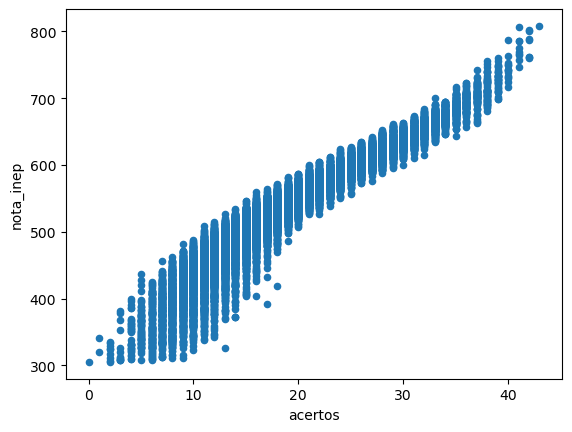

In [117]:
ch = pd.read_csv('data/ac_1_2022_CH.csv')

ch.plot(x='acertos',y='nota_inep',kind='scatter')

In [86]:
ch.sort_values('acertos',ascending=True)[:20]

,71466,73572,71445,73600,59663,73598,73669,72892,70994,73770,...,72290,59668,70799,73893,71384,71357,59128,acertos,caderno,nota_inep
401,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,93,284.7
5889,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,93,284.7
6100,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,93,284.7
6231,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,93,296.8
7847,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,95,296.8
1551,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,93,284.7
28031,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,96,296.8
24666,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,96,284.7
6124,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,93,368.5
21380,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,94,296.8
